tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


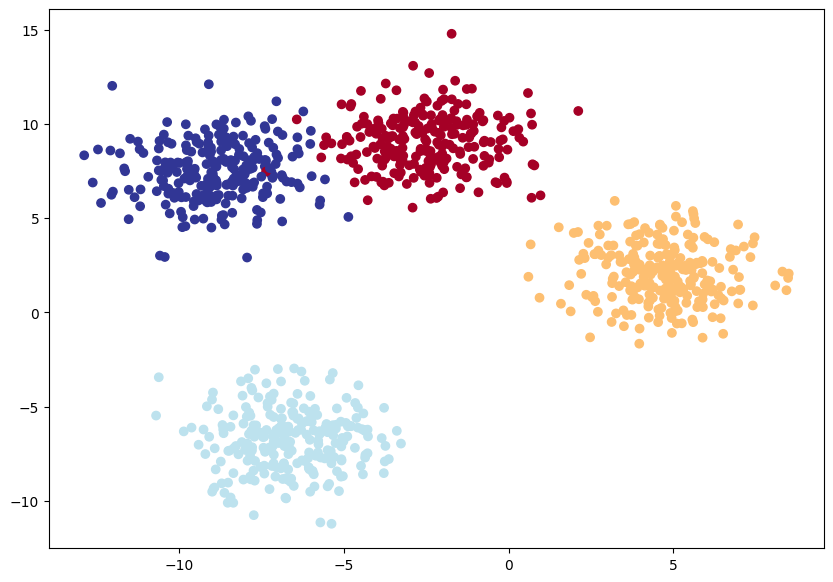

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# setting the hyper-parameters for data creation

num_classes = 4
num_features = 2

##  Create multi class data

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = num_features,  ## x FEATURES
                            centers = num_classes,  ## y LABELS
                            cluster_std = 1.5,  ## give the clusters a little shake up
                            random_state = 42)

### turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob[:5], y_blob[: 5])

## splot into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = 42)

plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu);

In [20]:
device = "cpu"

In [21]:
from torch import nn

class MultiClassModel(nn.Module):
  ### out_features = how many classes are there
  ### hidden_units = Number of hidden units between layers, default = 8
  def __init__(self, input_features, output_features, hidden_units = 8):

    super().__init__()

    self.linear_later_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_later_stack(x)

model = MultiClassModel(input_features = num_features,
                        output_features = num_classes,
                        hidden_units = 8).to(device)

model

MultiClassModel(
  (linear_later_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

## So after creating the model still the output is logits but what if we wanted to find out exact label it was giving the sample ?

`logits => prediction prob => prediction labels`

### Using softmax the prob of each prediction class being the actual predicted class compared to all other possible classes

In [23]:
model(X_blob_train.to(device))[: 5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [24]:
y_logits = model(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[: 5])
print(y_pred_probs[: 5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>)


In [25]:
## summing the first sample output of the softmax activation function

torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

### Which class does the model think is most likely at the the index 0 or 2 of the sample ?

In [26]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], grad_fn=<SelectBackward0>)
tensor(1)


In [27]:
print(y_pred_probs[2])
print(torch.argmax(y_pred_probs[2]))

tensor([0.3011, 0.1843, 0.2823, 0.2323], grad_fn=<SelectBackward0>)
tensor(0)


In [28]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []


torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for i in range(epochs):
  model.train()

  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)  ### logits -> prediction probabilities -> prediction labels

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true= y_blob_train,
                   y_pred = y_pred)

  train_loss_hist.append(loss.item())
  train_acc_hist.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():

    test_logits = model(X_blob_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_pred)

    test_loss_hist.append(test_loss.item())
    test_acc_hist.append(test_acc)

  if i % 10 == 0:
    print(f"Epoch: {i} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 0.81667, Test Acc: 68.50%
Epoch: 10 | Loss: 0.03970, Acc: 98.75% | Test Loss: 0.01952, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03161, Acc: 99.25% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 30 | Loss: 0.02219, Acc: 99.12% | Test Loss: 0.00606, Test Acc: 99.50%
Epoch: 40 | Loss: 0.01999, Acc: 99.50% | Test Loss: 0.00690, Test Acc: 99.50%
Epoch: 50 | Loss: 0.01866, Acc: 99.50% | Test Loss: 0.00842, Test Acc: 99.50%
Epoch: 60 | Loss: 0.01779, Acc: 99.50% | Test Loss: 0.00693, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01723, Acc: 99.38% | Test Loss: 0.00528, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01661, Acc: 99.38% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01617, Acc: 99.38% | Test Loss: 0.00472, Test Acc: 100.00%


In [30]:
final_train_loss = train_loss_hist[-1]
final_train_accuracy = train_acc_hist[-1]
final_test_loss = test_loss_hist[-1]
final_test_accuracy = test_acc_hist[-1]

print(f"Final Training Performance")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}% ")

Final Training Performance
Final Training Loss: 0.0159
Final Training Accuracy: 99.38%
Final Test Loss: 0.0042
Final Test Accuracy: 100.00% 


In [31]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)

y_logits[: 5]

tensor([[-18.3237,  21.5063, -52.0447, -39.1625],
        [  0.2762, -18.8129, -25.6507,   6.7659],
        [-44.4127, -50.4673,  38.5688,  -8.0357],
        [-22.6778,  24.1571, -40.0097, -36.0014],
        [  9.6104,  -8.1985, -36.7784, -11.9079]])

In [32]:
y_pred_probs = torch.softmax(y_logits, dim = 1)

y_preds = y_pred_probs.argmax(dim = 1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")


Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 100.0%


In [34]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


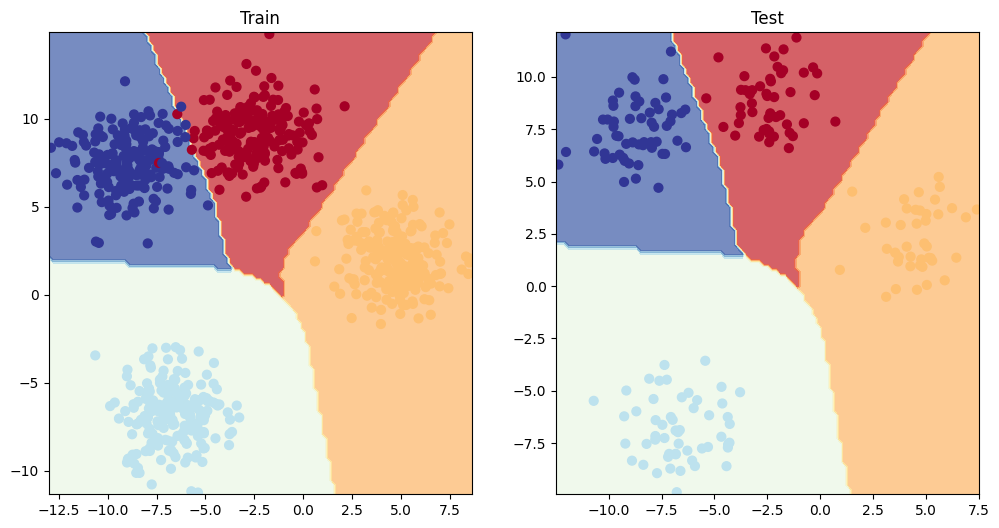

In [36]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)